In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import statsmodels.api as sm
from sklearn.feature_selection import mutual_info_classif
import numpy as np
from tabulate import tabulate
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
from sklearn.utils import resample


In [2]:
!pip freeze > requirements.txt

## EDA

Features wiki: 

1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not

In [2]:
df = pd.read_csv('data/healthcare-dataset-stroke-data.csv')

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
NUMERICAL_FEATURES = ['age', 'avg_glucose_level', 'bmi']
CATEGORICAL_FEATURES = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
TARGET = ['stroke']

### Null values analisys

In [6]:
## Calculate null values percentage on the dataset
null_percentage = ((df.isnull().sum() * 100) / len(df)).round(2)
null_percentage.astype(str) + '%'

id                    0.0%
gender                0.0%
age                   0.0%
hypertension          0.0%
heart_disease         0.0%
ever_married          0.0%
work_type             0.0%
Residence_type        0.0%
avg_glucose_level     0.0%
bmi                  3.93%
smoking_status        0.0%
stroke                0.0%
dtype: object

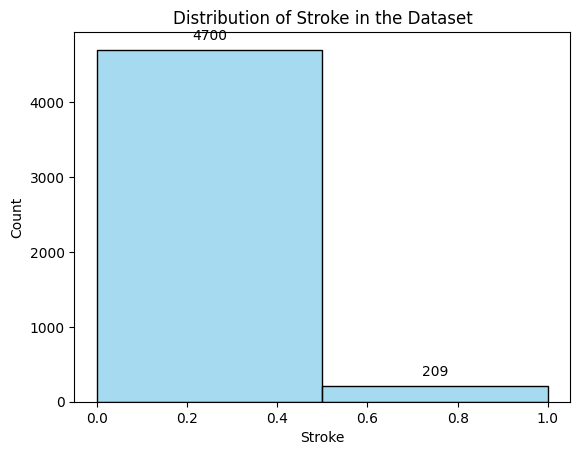

In [7]:
none_null_rows_df = df[~df['bmi'].isnull()]

ax = sns.histplot(data=none_null_rows_df, x='stroke', bins=2, kde=False, color='skyblue')
# Annotate the bars with their counts
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Set labels and title
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.title('Distribution of Stroke in the Dataset')

# Show the plot
plt.show()

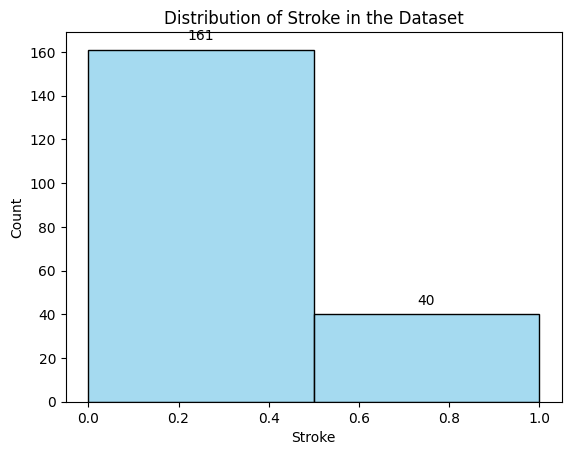

In [8]:
null_rows_df = df[df['bmi'].isnull()]

ax = sns.histplot(data=null_rows_df, x='stroke', bins=2, kde=False, color='skyblue')
# Annotate the bars with their counts
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Set labels and title
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.title('Distribution of Stroke in the Dataset')

# Show the plot
plt.show()


The percentage of null values for the BMI variable is low (3.93%), but it seems that the precense of a null value in the dataset might be informative with respect of the output value. To solve this: 

* Create new column with binary feature indicating if the value was missing

* Apply statistical imputation using the mean.

With this imputation techniques, we keep the information provided by the missing values

In [9]:
df['bmi_missing'] = df['bmi'].isnull().astype(int)
mean_bmi = df['bmi'].mean()
df['bmi'].fillna(mean_bmi, inplace=True)

### Numerical features

In [10]:
# Numerical Variables

num_df = df[NUMERICAL_FEATURES]
num_df

,age,avg_glucose_level,bmi
0,67.0,228.69,36.600000
1,61.0,202.21,28.893237
2,80.0,105.92,32.500000
3,49.0,171.23,34.400000
4,79.0,174.12,24.000000
...,...,...,...
5105,80.0,83.75,28.893237
5106,81.0,125.20,40.000000
5107,35.0,82.99,30.600000
5108,51.0,166.29,25.600000


In [11]:
# Calculate stats: 

# Mean:

print("### Mean: ")
print(num_df.mean())
print('\n')

# STD:

print("### Standard deviation: ")
print(num_df.std())
print('\n')

### Mean: 
age                   43.226614
avg_glucose_level    106.147677
bmi                   28.893237
dtype: float64


### Standard deviation: 
age                  22.612647
avg_glucose_level    45.283560
bmi                   7.698018
dtype: float64




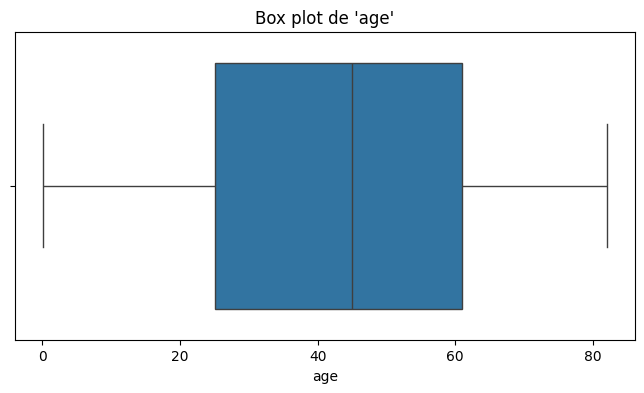

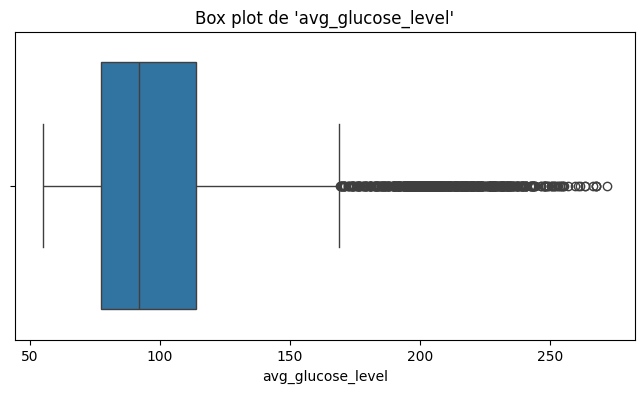

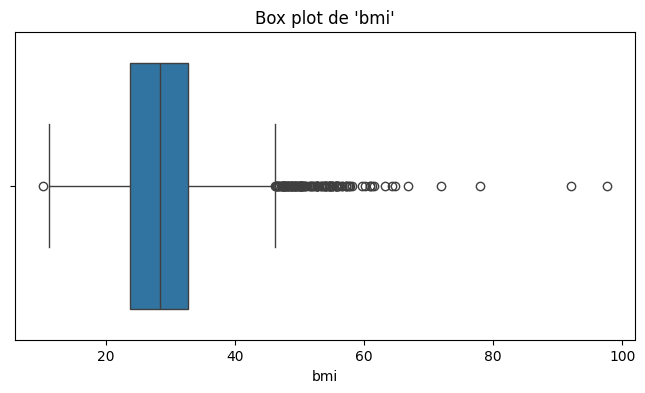

In [12]:
for column in num_df.columns:
    plt.figure(figsize=(8, 4))  
    sns.boxplot(x=num_df[column])
    plt.title(f"Box plot de '{column}'")
    plt.show()

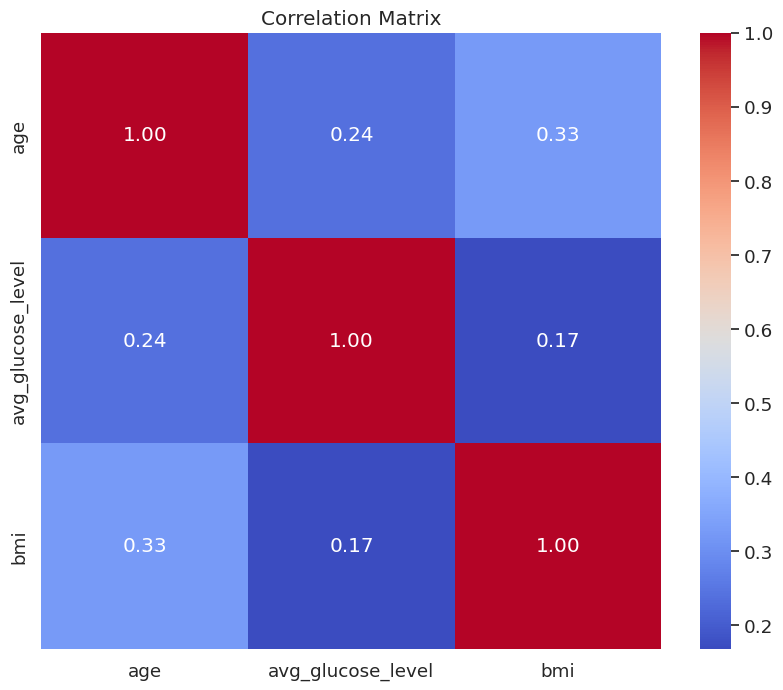

In [13]:
# CORRELATION MATRIX: for correlation matrix we add the target
num_df_target = df[NUMERICAL_FEATURES]
corr_matrix = num_df_target.corr()
plt.figure(figsize=(10, 8))  
sns.set(font_scale=1.2)  
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()

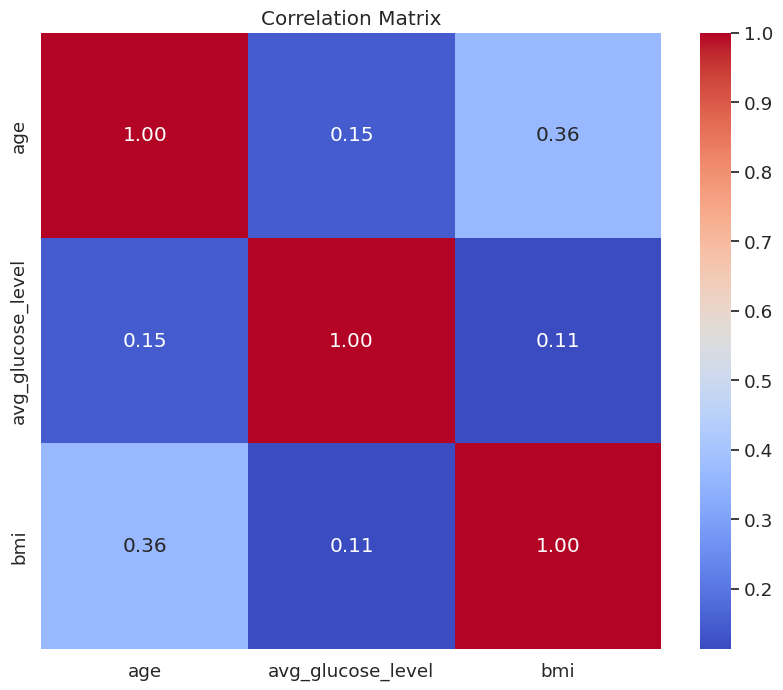

In [14]:
# CORRELATION MATRIX: for correlation matrix we add the target
num_df_target = df[NUMERICAL_FEATURES]
corr_matrix = num_df_target.corr(method='spearman')
plt.figure(figsize=(10, 8))  
sns.set(font_scale=1.2)  
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()

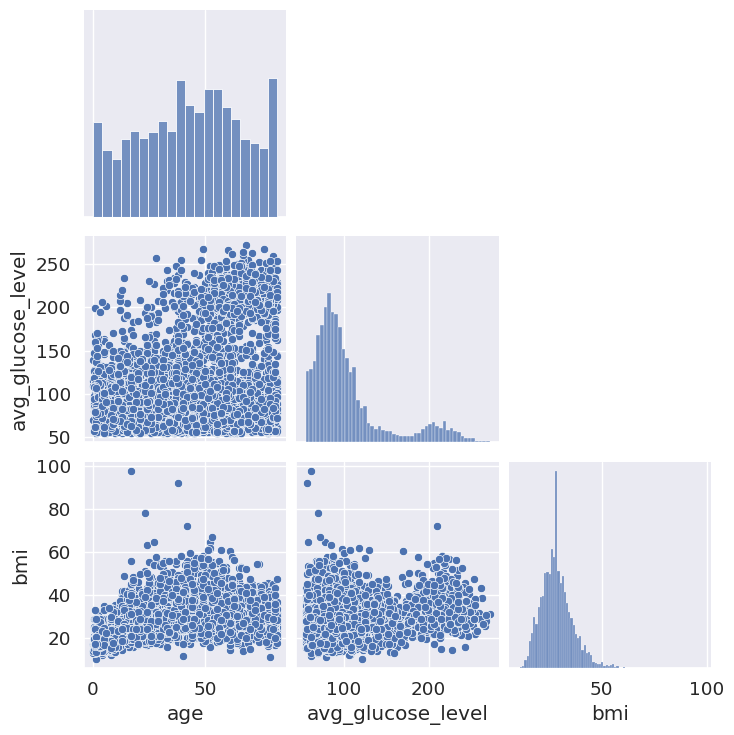

In [15]:
sns.pairplot(data=num_df_target, corner=True)

It seems that there is no a strong correlation between the numerical features.

Lets analyze the normality of the numerical variables: 

In [16]:
num_df.skew()

age                 -0.137059
avg_glucose_level    1.572284
bmi                  1.076716
dtype: float64

In [17]:
num_df.kurtosis()

age                 -0.991010
avg_glucose_level    1.680479
bmi                  3.623061
dtype: float64

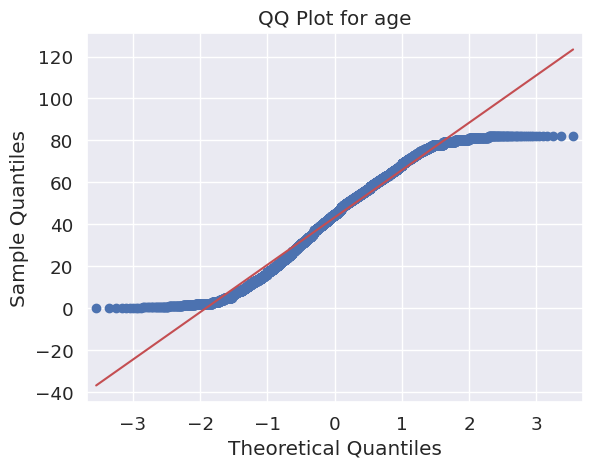

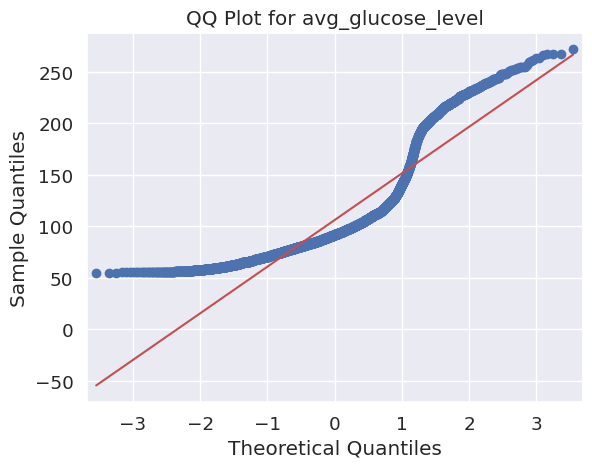

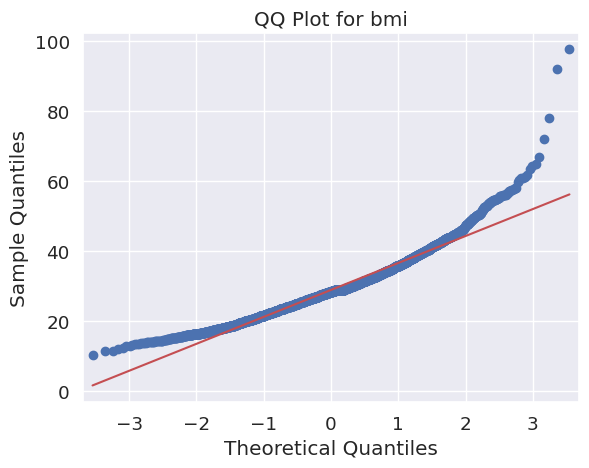

In [18]:
for variable in num_df.columns:
    sm.qqplot(df[variable], line='s')
    plt.title(f'QQ Plot for {variable}')
    plt.show()

By checking the skewness, Kurtosis and QQPlot we can see that the variables can not be asumed to be normal (This gives us a hint of not using Linear models)

Now, lets check how informative are this features with respect to the target value: 

In [19]:
## Calculate Mutual Information: 

# Separate features (X) and target variable (y)
X = num_df[['age', 'avg_glucose_level', 'bmi']]
y = df[TARGET]

# Compute mutual information
mi_scores = mutual_info_classif(X, y)

# Display the mutual information scores for each feature
for i, variable in enumerate(['age', 'avg_glucose_level', 'bmi']):
    print(f'Mutual Information between {variable} and stroke: {mi_scores[i]}')

Mutual Information between age and stroke: 0.03886014747461375
Mutual Information between avg_glucose_level and stroke: 0.0068969911282239504
Mutual Information between bmi and stroke: 0.012837106824566069


/home/octadesh/POSTGRADO_IA/apr_maquina/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


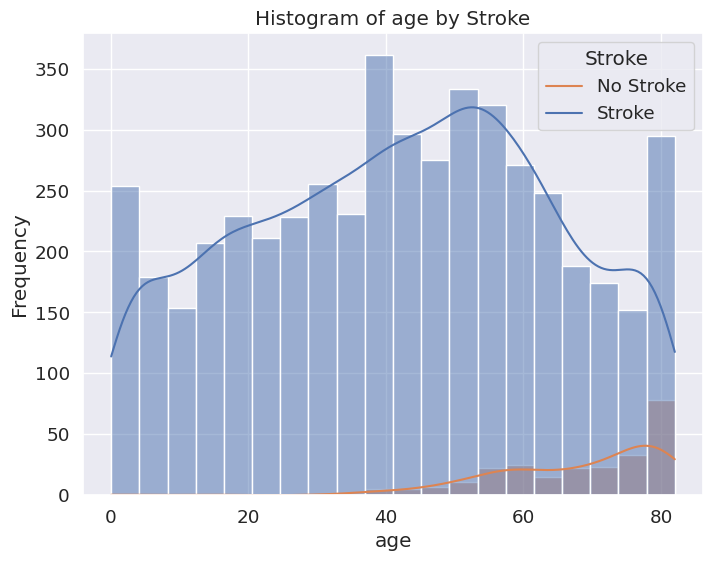

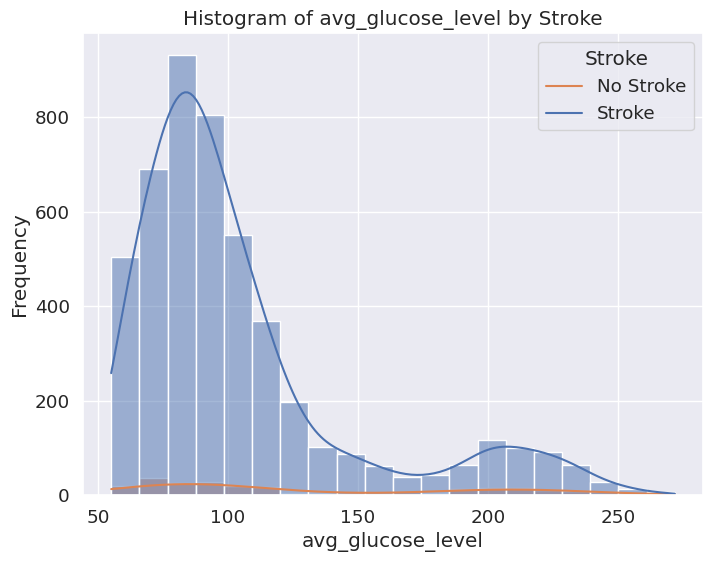

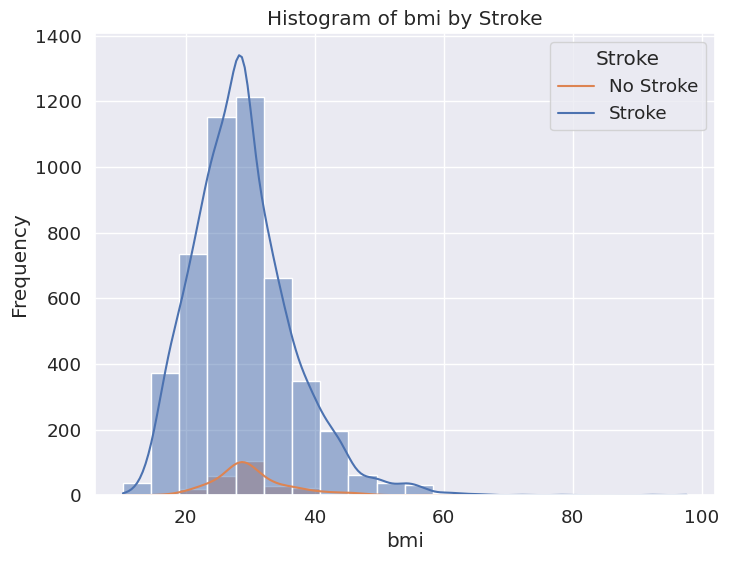

In [20]:
num_df_target = df[NUMERICAL_FEATURES + TARGET]
for variable in num_df.columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=num_df_target, x=variable, hue='stroke', kde=True, bins=20)
    plt.title(f'Histogram of {variable} by Stroke')
    plt.xlabel(variable)
    plt.ylabel('Frequency')
    plt.legend(title='Stroke', labels=['No Stroke', 'Stroke'])
    plt.show()

By seening the distributions of the numerical features, it can be seen that the Stroke classes does not seem to be separable by this values. Also, when calculating the Mutual Information between the Numerical Features and the target value all values are < 0.1, indicaating that there is some information shared between the variables, but it's relatively low, specially for 'bmi' and 'avg_glucose_level' wich are both lower than 0.01. 

### Categorical Features:

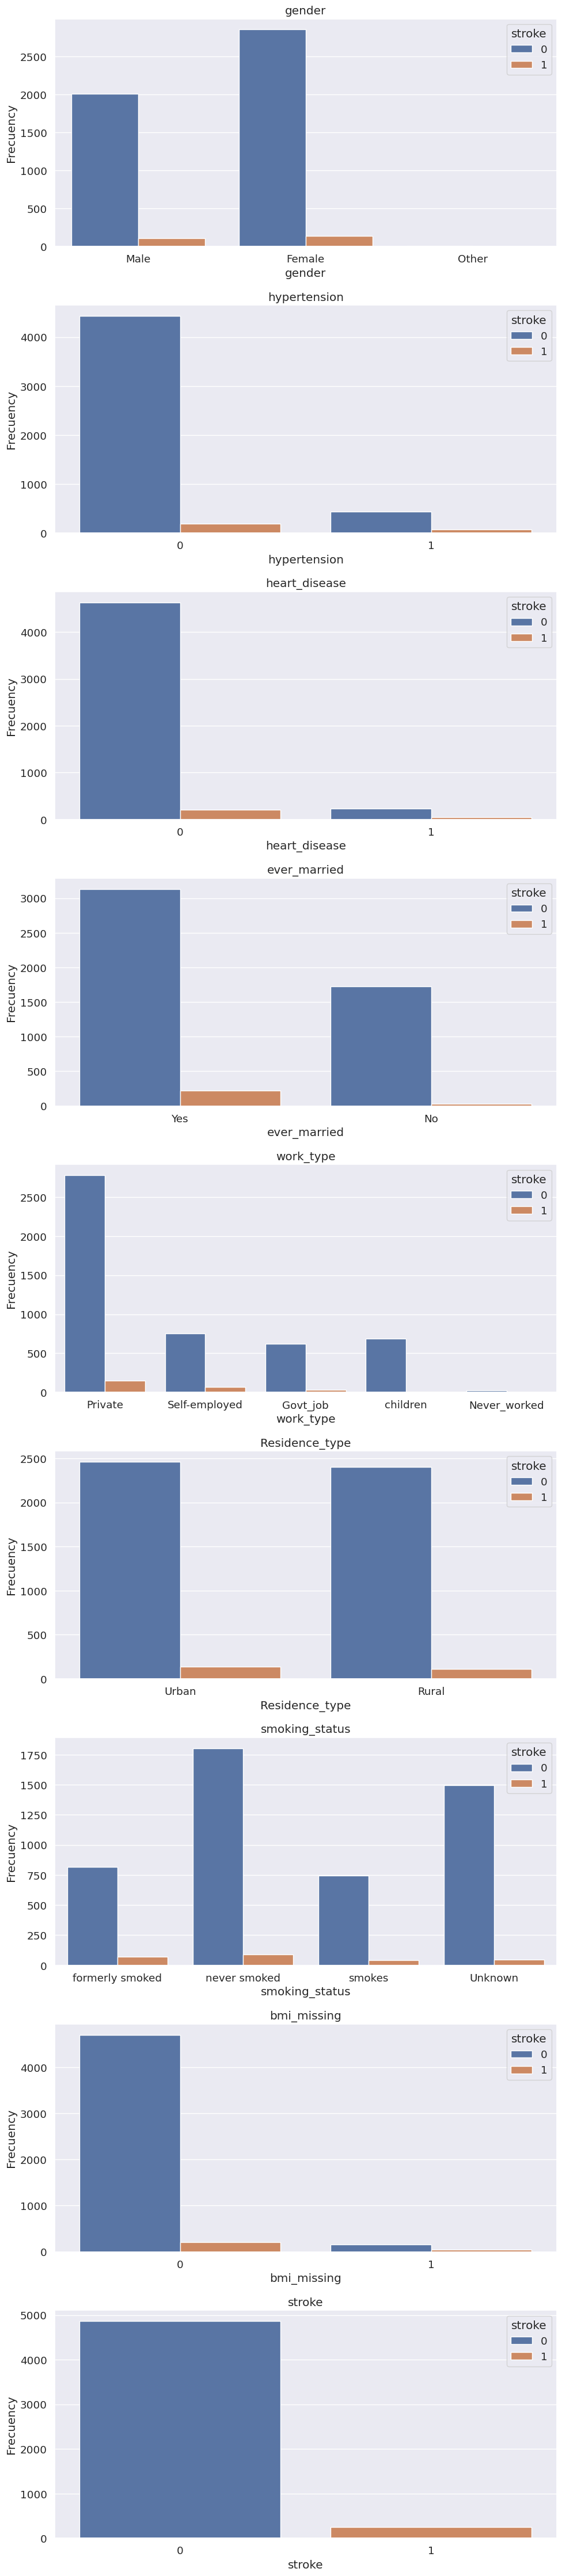

In [21]:
#Categorical variables
cat_df = df[CATEGORICAL_FEATURES + ['bmi_missing'] + TARGET]
cat_columns = len(cat_df.columns)
fig, axs = plt.subplots(cat_columns, figsize=(10, 5 * cat_columns)) 

for i, column in enumerate(cat_df.columns):
    sns.countplot(x=column, hue='stroke', data=cat_df, ax=axs[i])
    axs[i].set_title(column)
    axs[i].set_ylabel('Frecuency')
plt.tight_layout()
plt.show()


In [79]:
## Calculate Mutual Information: 

# Separate features (X) and target variable (y)
X = pd.get_dummies(cat_df)
y = df[TARGET]

# Compute mutual information
mi_scores = mutual_info_classif(X, y)

# Display the mutual information scores for each feature
for i, variable in enumerate(cat_df.columns):
    print(f'Mutual Information between {variable} and stroke: {mi_scores[i]}')

/home/octadesh/POSTGRADO_IA/apr_maquina/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mutual Information between gender and stroke: 0.009754728464090867
Mutual Information between hypertension and stroke: 0.006118145013670251
Mutual Information between heart_disease and stroke: 0.0027644795428942714
Mutual Information between ever_married and stroke: 0.19485061345003019
Mutual Information between work_type and stroke: 0.0021246994246049145
Mutual Information between Residence_type and stroke: 0.0
Mutual Information between smoking_status and stroke: 0.002386181831728562
Mutual Information between bmi_missing and stroke: 0.011423071048349831
Mutual Information between stroke and stroke: 0.0038039476920981308


hypertension, heart_desease, smoking_status and bmi_missing seems to be the most informative with respect to stroke. Althoug all of them have very low Mutual Information values withrespect to the target. 

## Features processing and selection

#### Features analisys

In [22]:


#Transfor categorical features: 

from sklearn.preprocessing import OneHotEncoder


transformed_df = df.copy()

transformed_df['ever_married'] = transformed_df['ever_married'].apply(lambda x: 1 if x =='Yes' else 0)


transformed_df['Residence_type'] = transformed_df['Residence_type'].apply(lambda x: 1 if x =='Urban' else 0)

transformed_df['gender'] = transformed_df['gender'].apply(lambda x: 1 if x =='Male' else 0)


# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')

# Fit and transform the specified columns
encoded_data = encoder.fit_transform(transformed_df[['work_type', 'smoking_status']])

# Create a DataFrame with the one-hot encoded features
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['work_type', 'smoking_status']))

# Concatenate the original DataFrame with the encoded DataFrame

transformed_df.drop('work_type', inplace=True, axis=1)
transformed_df.drop('smoking_status', inplace=True, axis=1)
transformed_df = pd.concat([transformed_df, encoded_df], axis=1)


#Drop id column as it is not informative: 
transformed_df.drop('id', inplace=True, axis=1)

# Select features:

#transformed_df = transformed_df[['ever_married', 'age', 'bmi_missing']]

transformed_df




/home/octadesh/POSTGRADO_IA/apr_maquina/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,bmi_missing,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,67.0,0,1,1,1,228.69,36.600000,1,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0,61.0,0,0,1,0,202.21,28.893237,1,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1,80.0,0,1,1,0,105.92,32.500000,1,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0,49.0,0,0,1,1,171.23,34.400000,1,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0,79.0,1,0,1,0,174.12,24.000000,1,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,0,80.0,1,0,1,1,83.75,28.893237,0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5106,0,81.0,0,0,1,1,125.20,40.000000,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5107,0,35.0,0,0,1,0,82.99,30.600000,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5108,1,51.0,0,0,1,0,166.29,25.600000,0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


Training was tested using different features selection criterias: all data, features with larger Mutual Information and 'Logicaly selected' features i.e. ones expects that
hipertension makes people more prone to have strokes, even though this does not reflect on data.

In [23]:
X = transformed_df.drop(columns=['stroke'])  # Features
y = transformed_df['stroke']  # Target variable

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Display the shapes of the resulting sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (3577, 16) (3577,)
Testing set shape: (1533, 16) (1533,)


In [24]:
from sklearn.preprocessing import StandardScaler

columns_to_scale = ['age', 'bmi']

scaler = StandardScaler()

# Fit and transform on the training set
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

# Transform the testing set using the same scaler
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])


In [25]:
#Lastly, split train in train and validation sets

# Split the data into training and validation sets (80% training, 20% testing)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (3577, 16) (3577,)
Testing set shape: (1533, 16) (1533,)


#### Manage imabalance on the dataset: 

It can be seen that there is a huge imbalance for the classes in the Target variable. To solve this we will apply undersampling of the most common category + resampling of the less frecuent category using SMOTE. 

<Axes: >

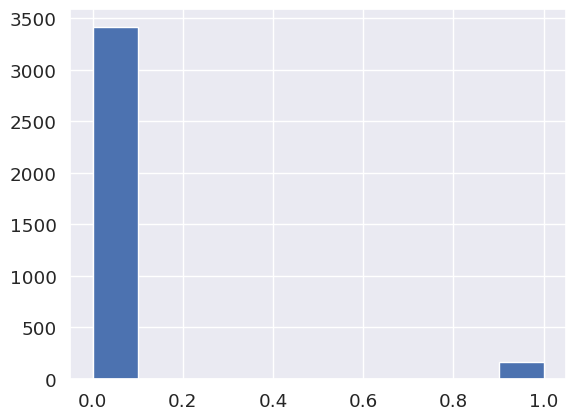

In [26]:
y_train.hist()

In [27]:
#Apply over sampling to reduce imbalance: 
# Separate majority and minority classes
train_data = pd.concat([pd.DataFrame(X_train), pd.Series(y_train)], axis=1)
majority_class = train_data[train_data['stroke'] == 0]
minority_class = train_data[train_data['stroke'] == 1]

# Upsample minority class
majority_class_downsampled = resample(majority_class, 
                                   replace=True,  
                                   n_samples=len(minority_class)*7, 
                                   random_state=42)  

# Combine majority class with upsampled minority class
train_upsampled = pd.concat([minority_class, majority_class_downsampled])

# Separate features and labels again
X_train_downsampled = train_upsampled.drop('stroke', axis=1)
y_train_downsampled = train_upsampled['stroke']


<Axes: >

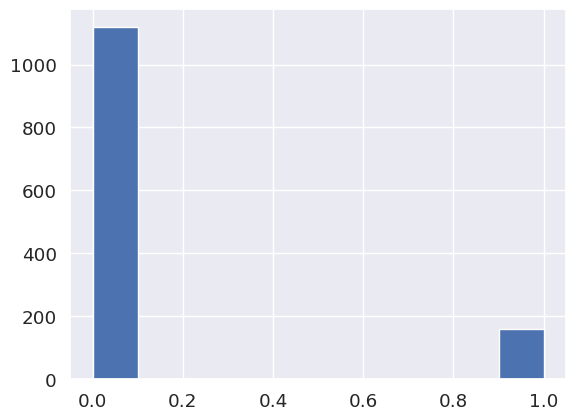

In [28]:
y_train_downsampled.hist()

In [29]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_downsampled, y_train_downsampled)


<Axes: >

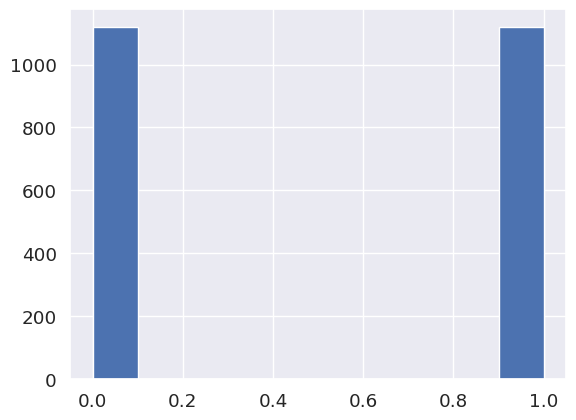

In [30]:
y_train_smote.hist()

## Model Trainning

In [31]:
def calculate_metrics(y_train, y_test,y_pred_train, y_pred):
    f1_train = f1_score(y_train, y_pred_train)
    f1 = f1_score(y_test, y_pred)

    precision_train = precision_score(y_train, y_pred_train)
    precision = precision_score(y_test, y_pred)

    recall_train = recall_score(y_train, y_pred_train)
    recall = recall_score(y_test, y_pred)

    # Create a DataFrame
    results_df = pd.DataFrame({
    'Metric': ['F1 Score', 'Precision', 'Recall'],
    'Training Set': [f1_train, precision_train, recall_train],
    'Test Set': [f1, precision, recall]
    })

    # Print the DataFrame using tabulate
    print("\nResults Summary:")
    table = tabulate(results_df, headers='keys', tablefmt='pretty', showindex=False)
    print(table)

    cm_train = confusion_matrix(y_train, y_pred_train)
    cm = confusion_matrix(y_test, y_pred)

    print(f"CM de entreamiento fue: \n{cm_train}")
    print(f"CM de testeo fue: \n{cm}")

In [32]:

from sklearn.tree import DecisionTreeClassifier

# Creamos el arbol
tree_classifier = DecisionTreeClassifier(criterion='entropy', splitter='best', 
                                        max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                                        random_state=42)
# Y entrenamos
tree_classifier.fit(X_train_smote, y_train_smote)

y_pred_train = tree_classifier.predict(X_train_smote)
y_pred = tree_classifier.predict(X_test)

calculate_metrics(y_train_smote, y_test, y_pred_train, y_pred)





Results Summary:
+-----------+--------------+---------------------+
|  Metric   | Training Set |      Test Set       |
+-----------+--------------+---------------------+
| F1 Score  |     1.0      | 0.22580645161290325 |
| Precision |     1.0      | 0.1583710407239819  |
|  Recall   |     1.0      | 0.39325842696629215 |
+-----------+--------------+---------------------+
CM de entreamiento fue: 
[[1120    0]
 [   0 1120]]
CM de testeo fue: 
[[1258  186]
 [  54   35]]


In [33]:
from sklearn.tree import export_graphviz
export_graphviz(tree_classifier, out_file = "tree_classifier.dot",feature_names=X_train.columns)

In [64]:
tree_classifier.tree_.node_count

253

In [65]:
tree_classifier.get_n_leaves()

127

We can see that the model has 127 leaf nodes, it is having an F1-Score of 1 on the trainning data and an F1-Score of 0.27 on the test data. This clearly indicates that the model is overfitting. 

Lets now do cross validation for different values of max_depth in order to find a more general model: 

In [36]:
from sklearn.model_selection import cross_val_score

In [62]:
# Hagamos Cross-validation para varios valores de profundidad del arbol
scores_list = []
depth_array = np.arange(1, 50)
leaf_array = np.zeros_like(depth_array)
for index, depth in enumerate(depth_array):
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=depth)
    scores_list.append(np.abs(cross_val_score(clf, X_train_smote, y_train_smote, cv=10, scoring='f1')))
    clf.fit(X_train_smote, y_train_smote)

scores_array = np.array(scores_list)
del scores_list

df_results_tree = pd.DataFrame({"depth": depth_array,
                           "f11": scores_array[:, 0],
                           "f12": scores_array[:, 1],
                           "f13": scores_array[:, 2],
                           "f14": scores_array[:, 3],
                           "f15": scores_array[:, 4]})

df_results_tree = pd.melt(df_results_tree, id_vars=['depth'], value_vars=["f11", "f12", "f13", "f14", "f15"])

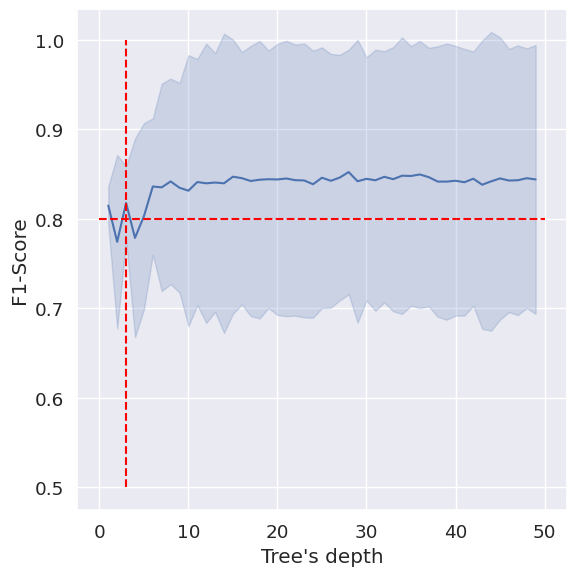

In [66]:
f, ax = plt.subplots(1,1, figsize=(6, 6))
sns.lineplot(data=df_results_tree, x="depth", y="value", errorbar="sd", ax=ax)
ax.plot([3, 3], [0.5, 1], color="red", linestyle="--")
ax.plot([0, 50], [0.8, 0.8], color="red", linestyle="--")

ax.set_xlabel("Tree's depth")
ax.set_ylabel("F1-Score")
plt.tight_layout()

We obtain that the model Cross Validation F1 mean curve it is stable and arround 0.85 for all trees with max depth larger than 5 but it can also be seen that the range arround the mean is large (0.7 - 0.9) This indicates low stability of the model across the different splits of the dataset. 

In [40]:
# Creamos el arbol
tree_classifier = DecisionTreeClassifier(criterion='entropy', splitter='best', 
                                        max_depth= 10, min_samples_split=2, min_samples_leaf=1, 
                                        random_state=42)
# Y entrenamos
tree_classifier.fit(X_train_smote, y_train_smote)

y_pred_train = tree_classifier.predict(X_train_smote)
y_pred = tree_classifier.predict(X_test)

calculate_metrics(y_train_smote, y_test, y_pred_train, y_pred)


Results Summary:
+-----------+--------------------+---------------------+
|  Metric   |    Training Set    |      Test Set       |
+-----------+--------------------+---------------------+
| F1 Score  | 0.9584070796460177 | 0.22699386503067487 |
| Precision |        0.95        | 0.15611814345991562 |
|  Recall   | 0.9669642857142857 | 0.4157303370786517  |
+-----------+--------------------+---------------------+
CM de entreamiento fue: 
[[1063   57]
 [  37 1083]]
CM de testeo fue: 
[[1244  200]
 [  52   37]]


It can be seen that the Decission Tree Classifier does not perform better than 0.21, wich for a binary classifier is much worse than deciding at random. We will try with a more complex model (Random Forest) to see if we obtain better metrics. 

In [67]:

# importamos RandomForestRegressor de los metodos de ensamble de sklearn.ensemble
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state = 42)
rf_classifier.fit(X_train_smote, y_train_smote)



y_pred_train = rf_classifier.predict(X_train_smote)
y_pred = rf_classifier.predict(X_test)

calculate_metrics(y_train_smote, y_test, y_pred_train, y_pred)




Results Summary:
+-----------+--------------+--------------------+
|  Metric   | Training Set |      Test Set      |
+-----------+--------------+--------------------+
| F1 Score  |     1.0      | 0.2723404255319149 |
| Precision |     1.0      | 0.2191780821917808 |
|  Recall   |     1.0      | 0.3595505617977528 |
+-----------+--------------+--------------------+
CM de entreamiento fue: 
[[1120    0]
 [   0 1120]]
CM de testeo fue: 
[[1330  114]
 [  57   32]]


Here the RandomForest model is also overfitting, so againg Cross Validation is applied in order to search for the best model parameters

In [68]:
# Lets do cross validation for the number of trees
scores_list = []
n_trees_array = np.arange(1, 100)
depth = 7
for index, n_trees in enumerate(n_trees_array):
    clf = RandomForestClassifier(criterion='entropy', max_depth=depth, n_estimators=n_trees)
    scores_list.append(np.abs(cross_val_score(clf, X_train_smote, y_train_smote, cv=10, scoring='f1')))
    clf.fit(X_train, y_train)

scores_array = np.array(scores_list)
del scores_list

df_results_rf = pd.DataFrame({"depth": n_trees_array,
                           "f11": scores_array[:, 0],
                           "f12": scores_array[:, 1],
                           "f13": scores_array[:, 2],
                           "f14": scores_array[:, 3],
                           "f15": scores_array[:, 4]})

df_results_rf = pd.melt(df_results_rf, id_vars=['depth'], value_vars=["f11", "f12", "f13", "f14", "f15"])

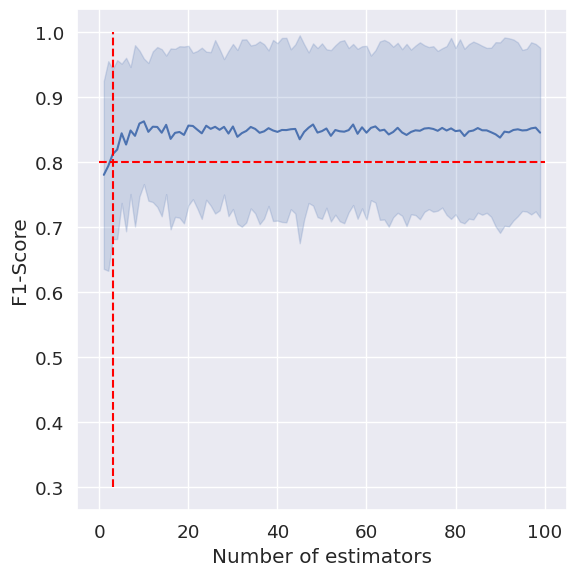

In [69]:
f, ax = plt.subplots(1,1, figsize=(6, 6))
sns.lineplot(data=df_results_rf, x="depth", y="value", errorbar="sd", ax=ax)
ax.plot([3, 3], [0.3, 1], color="red", linestyle="--")
ax.plot([0, 100], [0.8, 0.8], color="red", linestyle="--")

ax.set_xlabel("Number of estimators")
ax.set_ylabel("F1-Score")
plt.tight_layout()

In [76]:
# Lets do cross validation for estimators depth, fixing the number of estimators
scores_list = []
n_trees = 15
depth_array = np.arange(1, 30)
for index, depth in enumerate(depth_array):
    clf = RandomForestClassifier(criterion='entropy', max_depth=depth, n_estimators=n_trees)
    scores_list.append(np.abs(cross_val_score(clf, X_train_smote, y_train_smote, cv=10, scoring='f1')))
    clf.fit(X_train, y_train)

scores_array = np.array(scores_list)
del scores_list

df_results_rf_depth = pd.DataFrame({"depth": depth_array,
                           "f11": scores_array[:, 0],
                           "f12": scores_array[:, 1],
                           "f13": scores_array[:, 2],
                           "f14": scores_array[:, 3],
                           "f15": scores_array[:, 4]})

df_results_rf_depth = pd.melt(df_results_rf_depth, id_vars=['depth'], value_vars=["f11", "f12", "f13", "f14", "f15"])

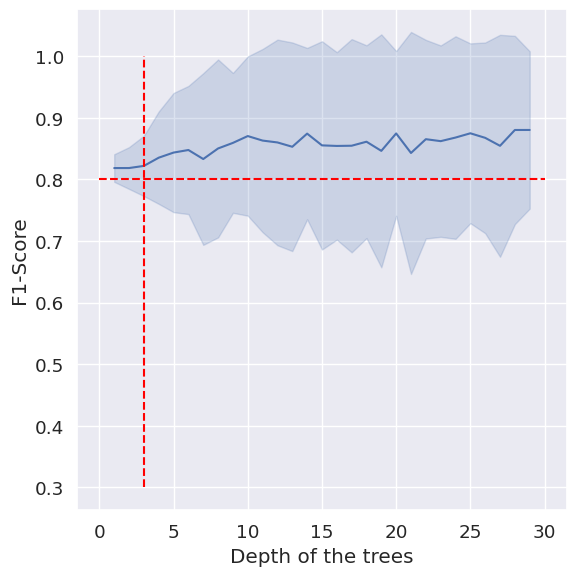

In [72]:
f, ax = plt.subplots(1,1, figsize=(6, 6))
sns.lineplot(data=df_results_rf_depth, x="depth", y="value", errorbar="sd", ax=ax)
ax.plot([3, 3], [0.3, 1], color="red", linestyle="--")
ax.plot([0, 30], [0.8, 0.8], color="red", linestyle="--")

ax.set_xlabel("Depth of the trees")
ax.set_ylabel("F1-Score")
plt.tight_layout()

In [75]:
rf_classifier = RandomForestClassifier(random_state = 42, max_depth=5, n_estimators=15)
rf_classifier.fit(X_train_smote, y_train_smote)
y_pred_train = rf_classifier.predict(X_train_smote)
y_pred = rf_classifier.predict(X_test)

calculate_metrics(y_train_smote, y_test, y_pred_train, y_pred)


Results Summary:
+-----------+--------------------+---------------------+
|  Metric   |    Training Set    |      Test Set       |
+-----------+--------------------+---------------------+
| F1 Score  | 0.8822790113112694 | 0.2697095435684647  |
| Precision | 0.8310970797158642 | 0.16539440203562342 |
|  Recall   | 0.9401785714285714 | 0.7303370786516854  |
+-----------+--------------------+---------------------+
CM de entreamiento fue: 
[[ 906  214]
 [  67 1053]]
CM de testeo fue: 
[[1116  328]
 [  24   65]]


For Random Forest, we obtain similar results to those obtained with The decission tree classifier. 

To avoid overfiting, now we will try with a simpler model, less prone to overfitting: LogisticRegression. 

In [77]:
from sklearn.linear_model import LogisticRegression

# Create a logistic regression model
logistic_regression = LogisticRegression()

# Fit the model to the training data
logistic_regression.fit(X_train_smote, y_train_smote)

# Make predictions on the test data
y_pred = logistic_regression.predict(X_test)
y_pred_train = logistic_regression.predict(X_train_smote)


calculate_metrics(y_train_smote, y_test, y_pred_train, y_pred)


Results Summary:
+-----------+--------------------+---------------------+
|  Metric   |    Training Set    |      Test Set       |
+-----------+--------------------+---------------------+
| F1 Score  | 0.8323197219808862 | 0.2577962577962578  |
| Precision | 0.8104906937394247 | 0.15816326530612246 |
|  Recall   | 0.8553571428571428 | 0.6966292134831461  |
+-----------+--------------------+---------------------+
CM de entreamiento fue: 
[[896 224]
 [162 958]]
CM de testeo fue: 
[[1114  330]
 [  27   62]]


/home/octadesh/POSTGRADO_IA/apr_maquina/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


After fitting the LogisticRegression model, even though here we do not have overfitting as it was expected, but the test results are still very poor. 

Also, it can be seen that Sklearn output the message: 

* ConvergenceWarning: lbfgs failed to converge (status=1): STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Wich indicates that there is no convergence in during fitting i.e. the algorithm is not finding an acceptable solution. 

### Conclusions

The selected dataset presented two important issues: 
* Huge imbalance between target classes (aproximatly x20)
* Uninformative features: Target class distributions overlap for all the features, except for some minor differeces for age and ever_married. 

To solve this issues, different models, feature selection combination and dataset balancing techniques were applied but it was not possible to train a Machine Learning model capable of predicting if a person is having a stroke or not based on the provided data. 

Therefore, the main conclussion is that more data must be collected in order to train a model for Stroke Prediction. 